In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import random, numpy as jnp
from pc2 import Network, Module, Dense, Sequential
import datasets
from PIL import Image
import matplotlib.pyplot as plt
# from clu import metrics
import flax
import flax.linen as nn
import datasets
import numpy.random as npr


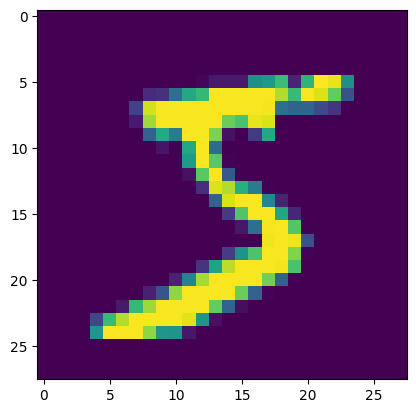

In [2]:
train_images, train_labels, test_images, test_labels = datasets.mnist()
plt.imshow(jnp.reshape(train_images[0], (28,28)))


In [3]:
batch_size = 1024
train_images, train_labels, test_images, test_labels = datasets.mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()


In [4]:
class MLP(nn.Module):
    # def setup(self):
    #     self.dense1 = nn.Dense(1024)
    #     self.dense2 = nn.Dense(10)

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1024)(x)
        # x = self.dense1(x)
        x = nn.tanh(x)
        x = nn.Dense(10)(x)
        # x = self.dense2(x)
        x = nn.activation.softmax(x)
        return x

model = MLP()

In [5]:
key1, key2 = random.split(random.key(0))
train_size=1000
x = train_images[0:train_size]
y = train_labels[0:train_size]
print(x.shape, y.shape)
params = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

(1000, 784) (1000, 10)


{'params': {'Dense_0': {'bias': (1024,), 'kernel': (784, 1024)},
  'Dense_1': {'bias': (10,), 'kernel': (1024, 10)}}}

In [6]:
model.apply(params, x)


Array([[0.04699855, 0.07517353, 0.07229667, ..., 0.13136439, 0.1209725 ,
        0.06899231],
       [0.04957927, 0.07826361, 0.0543289 , ..., 0.09494812, 0.114541  ,
        0.07375124],
       [0.07304829, 0.07933359, 0.10769977, ..., 0.13269468, 0.10561708,
        0.07004561],
       ...,
       [0.05949913, 0.08842745, 0.06820785, ..., 0.07883118, 0.09160868,
        0.10491852],
       [0.08793209, 0.09765116, 0.06932477, ..., 0.09212617, 0.10404621,
        0.08604551],
       [0.08983723, 0.11864541, 0.06745436, ..., 0.14635032, 0.09474164,
        0.08494898]], dtype=float32)

In [7]:
# Same as JAX version but using model.apply().
@jax.jit
def cross_entropy_loss(params, x_batched, y_batched):
  def cross_entropy(x, y):
    pred = model.apply(params, x)
    return -jnp.sum(y * jnp.log(pred))
  return jnp.mean(jax.vmap(cross_entropy)(x_batched,y_batched), axis=0)


In [8]:
def accuracy(params, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(model.apply(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)


In [9]:
learning_rate = 0.1  # Gradient step size.
loss_grad_fn = jax.value_and_grad(cross_entropy_loss)
print(loss_grad_fn)

@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

for i in range(501):
  # Perform one gradient update.
  for _ in range(num_batches):
    x, y = next(batches)
    loss_val, grads = loss_grad_fn(params, x, y)
    params = update_params(params, learning_rate, grads)

  if i % 10 == 0:
    print(f'Loss step {i}: ', loss_val)
    train_acc = accuracy(params, (train_images, train_labels))
    test_acc = accuracy(params, (test_images, test_labels))
    print(f"Training set accuracy {train_acc*100:0.2f}%")
    print(f"Test set accuracy {test_acc*100:0.2f}%")


<function cross_entropy_loss at 0x7f4e70181c60>
Loss step 0:  0.53155446
Training set accuracy 86.86%
Test set accuracy 87.72%
Loss step 10:  0.2999451
Training set accuracy 91.64%
Test set accuracy 91.85%
Loss step 20:  0.2615211
Training set accuracy 92.41%
Test set accuracy 92.60%
Loss step 30:  0.2953677
Training set accuracy 93.10%
Test set accuracy 93.05%
Loss step 40:  0.17308256
Training set accuracy 93.86%
Test set accuracy 93.62%
Loss step 50:  0.22357145
Training set accuracy 94.53%
Test set accuracy 94.21%
Loss step 60:  0.17435804
Training set accuracy 95.05%
Test set accuracy 94.63%
Loss step 70:  0.17509212
Training set accuracy 95.71%
Test set accuracy 95.24%
Loss step 80:  0.14026102
Training set accuracy 96.08%
Test set accuracy 95.71%
Loss step 90:  0.103190586
Training set accuracy 96.53%
Test set accuracy 96.04%
Loss step 100:  0.12776417
Training set accuracy 96.89%
Test set accuracy 96.33%
Loss step 110:  0.11034234
Training set accuracy 97.15%
Test set accuracy 

In [10]:
a = jax.random.normal(key1, (3,3))
b = jax.random.normal(key1, (3,3))
a * b

Array([[6.8150144e+00, 1.1460138e-03, 1.1801200e+00],
       [2.1912851e+00, 2.3726006e+00, 1.1289402e+00],
       [2.9349127e-01, 2.8977572e-04, 7.4130140e-02]], dtype=float32)

In [12]:
print(model.scope)

None


In [13]:
print(params)

{'params': {'Dense_0': {'bias': Array([-0.04238342,  0.0446732 ,  0.04759712, ..., -0.03485369,
        0.03680721, -0.00253925], dtype=float32), 'kernel': Array([[ 0.07971383,  0.00994104, -0.03574973, ...,  0.00628182,
         0.02120237,  0.02002901],
       [ 0.04412211,  0.0430598 , -0.04036054, ...,  0.03124418,
        -0.04736134, -0.02334021],
       [ 0.01488651,  0.03339985,  0.03590554, ...,  0.04288763,
        -0.01492494,  0.04700463],
       ...,
       [-0.00046571,  0.04048149, -0.03295735, ...,  0.0106256 ,
         0.05399278,  0.0324134 ],
       [-0.01125758, -0.00655999, -0.02332083, ...,  0.00946312,
         0.00079829,  0.01359766],
       [ 0.02846446, -0.0003765 ,  0.0099156 , ...,  0.00535347,
         0.02542572, -0.07208928]], dtype=float32)}, 'Dense_1': {'bias': Array([-0.14579825,  0.31478858,  0.09580804, -0.12262518, -0.09328156,
        0.45574516, -0.06302801,  0.32906225, -0.7084837 , -0.06215745],      dtype=float32), 'kernel': Array([[ 0.0378584

: 